# ⚡ 200W 四开关 Buck-Boost (FSBB) 硬件参数计算书

**项目**: BIDIR-4SW-BUCKBOOST
**作者**: wxw
**日期**: 2025-11-29

---

## 1. 设计规格 (Design Specifications)

首先定义系统的全局输入参数。

| 参数 | 符号 | 数值 | 单位 | 说明 |
| :--- | :--- | :--- | :--- | :--- |
| **最小输入电压** | $V_{in\_min}$ | 10 | V | 电池放电截止电压 |
| **最大输入电压** | $V_{in\_max}$ | 30 | V | 适配器/电池充满电压 |
| **额定输出电压** | $V_{out}$ | 24 | V | 目标稳压值 |
| **最大输出功率** | $P_{max}$ | 200 | W | 短时峰值功率 |
| **开关频率** | $f_{sw}$ | 100 | kHz | |
| **预估效率** | $\eta$ | 0.95 | - | 用于计算输入电流 |
| **纹波率目标** | $r_{ripple}$ | 0.3 | - | 30% 纹波系数 |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# --- 1. System Inputs ---
Vin_min = 10.0   # V
Vin_max = 30.0   # V
Vout    = 24.0   # V
Pmax    = 200.0  # W
fsw     = 100e3  # Hz
eta     = 0.95   # Efficiency estimate
r_ripple= 0.3    # 30% Ripple ratio

print("✅ 系统参数初始化完成")

Matplotlib is building the font cache; this may take a moment.


✅ 系统参数初始化完成


## 2. 系统电流应力分析 (Current Stress Analysis)

在进行电感选型前，我们需要计算最恶劣情况下的电流。对于 Buck-Boost 拓扑：
1.  **最大输出电流**: $I_{out\_max} = P_{max} / V_{out}$
2.  **最大输入电流** (发生在 $V_{in}$ 最低时): $I_{in\_max} = P_{max} / (V_{in\_min} \cdot \eta)$

电感平均电流的最大值 $I_{L\_avg\_max}$ 近似等于 $I_{in\_max}$ (在 Boost 模式下)。

In [2]:
# --- 2. Current Calculations ---

# Max Output Current
Iout_max = Pmax / Vout

# Max Input Current (Worst Case at Vin_min)
Iin_max = Pmax / (Vin_min * eta)

# Target Inductor Ripple Current (Delta I_L)
# We design ripple based on the maximum average current
Delta_IL_target = Iin_max * r_ripple

print(f"I_out_max  = {Iout_max:.2f} A")
print(f"I_in_max   = {Iin_max:.2f} A (Inductor Average Max)")
print(f"Target Ripple = {Delta_IL_target:.2f} A")

I_out_max  = 8.33 A
I_in_max   = 21.05 A (Inductor Average Max)
Target Ripple = 6.32 A


## 3. 磁性元件设计 (Inductor Selection)

我们需要分别计算 Buck 和 Boost 模式下所需的最小电感量，并取最大值。

### 3.1 Buck 模式 ($V_{in} > V_{out}$)
最恶劣工况通常发生在 $V_{in\_max}$ 时。
$$L_{buck} \ge \frac{(V_{in} - V_{out}) \cdot V_{out}}{V_{in} \cdot f_{sw} \cdot \Delta I_L}$$

### 3.2 Boost 模式 ($V_{in} < V_{out}$)
最恶劣工况发生在 $V_{in\_min}$ 时 (此时占空比最大，纹波虽不是最大但电流应力最大，通常用 $50\%$ 占空比估算纹波最恶劣点)。
$$L_{boost} \ge \frac{V_{in} \cdot (V_{out} - V_{in})}{V_{out} \cdot f_{sw} \cdot \Delta I_L}$$

*注意：为了严谨，我们编写一个函数遍历所有输入电压，找到 L 的最大需求值。*

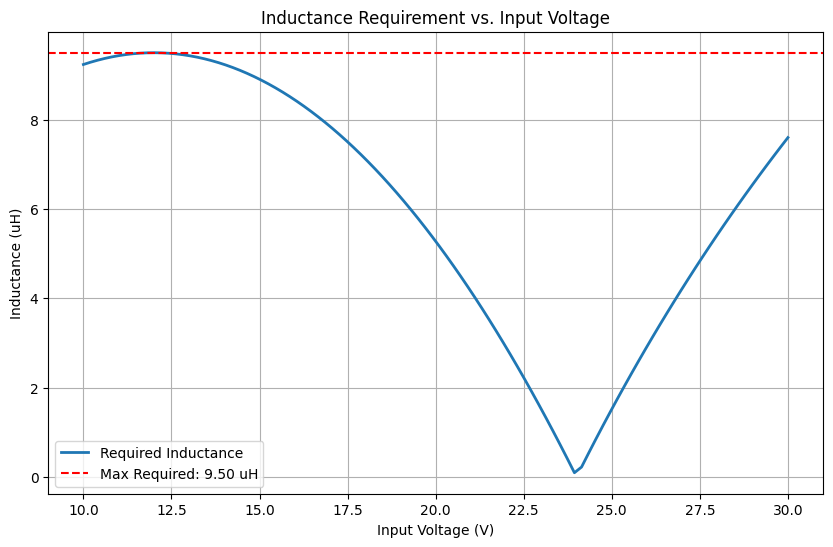

Calculated Min Inductance: 9.50 uH
Selected Inductance: 22.0 uH


In [4]:
# --- 3. Inductor Sizing & Visualization ---

# Create a voltage range from 10V to 30V
Vin_range = np.linspace(Vin_min, Vin_max, 100)
L_req_curve = []

for V in Vin_range:
    if V > Vout:
        # Buck Mode
        D = Vout / V
        # Ripple formula for Buck
        L_val = (V - Vout) * D / (fsw * Delta_IL_target)
    else:
        # Boost Mode
        D = (Vout - V) / Vout
        # Ripple formula for Boost
        L_val = V * D / (fsw * Delta_IL_target)
    
    L_req_curve.append(L_val * 1e6) # Convert to uH

# Find max required L
L_min_req = max(L_req_curve)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(Vin_range, L_req_curve, linewidth=2, label='Required Inductance')
plt.axhline(y=L_min_req, color='r', linestyle='--', label=f'Max Required: {L_min_req:.2f} uH')
plt.xlabel('Input Voltage (V)')
plt.ylabel('Inductance (uH)')
plt.title('Inductance Requirement vs. Input Voltage')
plt.legend()
plt.grid(True)
plt.show()

# Final Selection
print(f"Calculated Min Inductance: {L_min_req:.2f} uH")
L_select = 22.0 # uH (Engineering Standard Value)
print(f"Selected Inductance: {L_select} uH")

## 4. 饱和电流检查 (Saturation Check)

选定 $L = 22 \mu H$ 后，我们需要反算实际的纹波电流和峰值电流，确保电感不饱和。

$$I_{peak} = I_{L\_avg\_max} + \frac{\Delta I_{L\_actual}}{2}$$

In [5]:
# --- 4. Peak Current Check ---

# Recalculate Ripple at worst case (Boost mode, Vin_min)
D_max_boost = (Vout - Vin_min) / Vout
Delta_IL_actual = (Vin_min * D_max_boost) / (fsw * (L_select * 1e-6))

# Peak Current
I_peak = Iin_max + (Delta_IL_actual / 2)

print(f"Selected L: {L_select} uH")
print(f"Actual Ripple Current: {Delta_IL_actual:.2f} A")
print(f"⚠️ Inductor Peak Current: {I_peak:.2f} A")
print(f"-> Specification Required: Saturation Current (Isat) > {math.ceil(I_peak)} A")

Selected L: 22.0 uH
Actual Ripple Current: 2.65 A
⚠️ Inductor Peak Current: 22.38 A
-> Specification Required: Saturation Current (Isat) > 23 A


## 5. 输出电容计算 (Output Capacitor)

输出电容主要由 Boost 模式下的纹波电压决定（因为 Boost 模式下输出电流不连续）。
目标纹波电压: $\Delta V_{out} = 1\% \cdot V_{out} = 0.24V$

$$C_{out} \ge \frac{I_{out\_max} \cdot D_{max}}{f_{sw} \cdot \Delta V_{out}}$$

In [6]:
# --- 5. Capacitor Sizing ---

V_ripple_target = 0.01 * Vout # 1%

# Worst case duty cycle (Boost mode)
D_max = (Vout - Vin_min) / Vout

C_req = (Iout_max * D_max) / (fsw * V_ripple_target)

print(f"Required Output Capacitance: {C_req * 1e6:.2f} uF")
print(f"-> Recommendation: Use 2x 470uF Electrolytic + 4x 10uF Ceramic")

Required Output Capacitance: 202.55 uF
-> Recommendation: Use 2x 470uF Electrolytic + 4x 10uF Ceramic


## 6. 结论 (Conclusion / BOM)

基于上述计算，关键元器件参数如下：

| Component | Parameter | Calculated Value | Recommended Spec |
| :--- | :--- | :--- | :--- |
| **Inductor** | Value ($L$) | $> 9.2 \mu H$ | **22 uH** |
| **Inductor** | Saturation ($I_{sat}$) | $> 24.2 A$ | **> 30 A** |
| **MOSFET** | Voltage ($V_{DS}$) | $> 30 V$ | **60 V** |
| **MOSFET** | Current ($I_{D}$) | $RMS \approx 21 A$ | **> 80 A** |
| **Capacitor** | Output ($C_{out}$) | $> 202 \mu F$ | **2x 470uF** |